# Prepare Basin Averaged Forcing for NGEN

**Authors:**  
   - Tony Castronova <acastronova@cuahsi.org>    
   - Irene Garousi-Nejad <igarousi@cuahsi.org>  
    
**Last Updated:** 05.03.2023   

**Description**:  

The purpose of this Jupyter Notebook is to demonstrate how to prepare basin averaged forcing input from for the [NOAA Next Generation (NextGen) Water Resource Modeling Framework](https://github.com/NOAA-OWP/ngen). This notebook demonstrates how these data can be prepared from AORC v1.1 however a similar process can be applied to other datasets.

**Software Requirements**:  

The software and operating system versions used to develop this notebook are listed below. To avoid encountering issues related to version conflicts among Python packages, we recommend creating a new environment variable and installing the required packages specifically for this notebook.

Tested on: MacOS Ventura 13.2.1 (`python: 3.10.8`) 

> dask: 2022.12.1  
  distributed: 2022.12.1  
  geopandas: 0.12.2   
  numpy: 1.23.5   
  xarray: 2022.12.0  
  pyproj: 3.4.1             
  pandas: 1.5.2  
  requests: 2.28.1  
  rioxarray: 0.13.3  
  geocube: 0.3.3   


In [1]:
import re
import dask
import numpy
import xarray
import pyproj
import pandas
import requests
import geopandas
import rioxarray as rio
from matplotlib import colors
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from dask.distributed import Client
from dask.distributed import progress
from geocube.api.core import make_geocube

Initiate the Dask client. This will enable us to parallelize our computations.

In [2]:
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print(client.dashboard_link)
except:    
    # The client should be customized to your workstation resources.
    # This is configured for a "Large" instance on ciroh.awi.2i2c.cloud
    # client = Client()
    client = Client(n_workers=8, memory_limit='30GB') # Large Machine
    print(client.dashboard_link)

/user/igarousi/proxy/8787/status


---

### Load Forcing Data into Memory

In this notebook we'll be working with AORC v1.1 meteorological forcing. These data are publicly available for the `HUC 16` region from 01/01/2010 - 12/31/2010.

In [3]:
wb_id = 'wb-2917503'

In [4]:
# define the paths that will be used to load the data.
catalog_base_url = 'https://thredds.hydroshare.org/thredds/catalog'
dods_base_url = 'https://thredds.hydroshare.org/thredds/dodsC'
url = f'{catalog_base_url}/aorc/data/v1.1/16/catalog.xml'
root = ET.fromstring(requests.get(url).text)
ns = '{http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0}'

Locate the datasets that are available by querying the Thredds Catalog.

In [5]:
# use xpath top select all "dataset" elements.
elems = root.findall(f'.//{ns}dataset')

# loop through results and extract the "urlPath" attribute values
paths = []
for elem in elems:
    atts = elem.attrib
    if 'urlPath' in atts.keys():
        paths.append(f"{dods_base_url}/{atts['urlPath']}")
        
# use regex to isolate only files that end with ".nc"
paths = list(filter(re.compile("^.*\.nc$").match, paths))

Load the dataset using `xarray` and add spatial metadata to it.

In [7]:
ds = xarray.open_mfdataset(paths,
                           concat_dim='time',
                           combine='nested',
                           parallel=True,
                           chunks={'time': 10, 'x': 285, 'y':275},
                           engine='netcdf4'
                          )

ds_meta = xarray.open_dataset('http://thredds.hydroshare.org/thredds/dodsC/hydroshare/resources/2a8a3566e1c84b8eb3871f30841a3855/data/contents/WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc')

leny = len(ds_meta.y)
x = ds_meta.x[373 : 1227 + 1].values
y = ds_meta.y[leny - 2405 - 1 : leny - 1586].values

X, Y = numpy.meshgrid(x, y)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = pyproj.Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))
ds = ds.assign_coords(x = x)
ds = ds.assign_coords(y = y)

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'
ds.x.attrs['resolution'] = 1000.  # cell size

ds.y.attrs['axis'] = 'Y' 
ds.y.attrs['standard_name'] = 'projection_y_coordinate'
ds.y.attrs['long_name'] = 'y-coordinate in projected coordinate system'
ds.y.attrs['resolution'] = 1000.  # cell size

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude' 
ds.lon.attrs['long_name'] = 'longitude'

ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude' 
ds.lat.attrs['long_name'] = 'latitude'

# add crs to netcdf file
ds.rio.write_crs(ds_meta.crs.attrs['spatial_ref'], inplace=True
                ).rio.set_spatial_dims(x_dim="x",
                                            y_dim="y",
                                            inplace=True,
                                           ).rio.write_coordinate_system(inplace=True);


Load the geodatabase of our `ngen` domain. This can be obtained using the `subset-ngen-hydrofabric.ipynb` notebook.

In [8]:
# prepare geometries for spatial averaging
gdf = geopandas.read_file(f'{wb_id}/config/{wb_id}_upstream_subset.gpkg', layer='divides')

# convert these data into the projection of our forcing data
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

gdf = gdf.to_crs(target_crs.crs)


Add catchment ids to the AORC dataset. These will be used to perform zonal statistics later on.

In [9]:
# create zonal id column
gdf['cat'] = gdf.id.str.split('-').str[-1].astype(int)

# clip AORC to the extent of the hydrofabric geometries
ds = ds.rio.clip(gdf.geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False)

# select a single array of data to use as a template
lwdown_data = ds.isel(time=0).LWDOWN

# create a grid for the geocube
out_grid = make_geocube(
    vector_data=gdf,
    measurements=["cat"],
    like=ds # ensure the data are on the same grid
)

# add the catchment variable to the original dataset
ds = ds.assign_coords(cat = (['y','x'], out_grid.cat.data))

# compute the unique catchment IDs which will be used to compute zonal statistics
catchment_ids = numpy.unique(ds.cat.data[~numpy.isnan(ds.cat.data)])

print(f'The dataset contains {len(catchment_ids)} catchments')

The dataset contains 31 catchments


Preview the gridded catchments over the watershed vector boundary. Note that the method we're using will associate grid cell with the watershed that it overlaps the most with. There are more advanced ways to create a mapping using various interpolation methods that will distribute values cells across all watershed boundaries that they intersect with. This is left as a future exercize. 

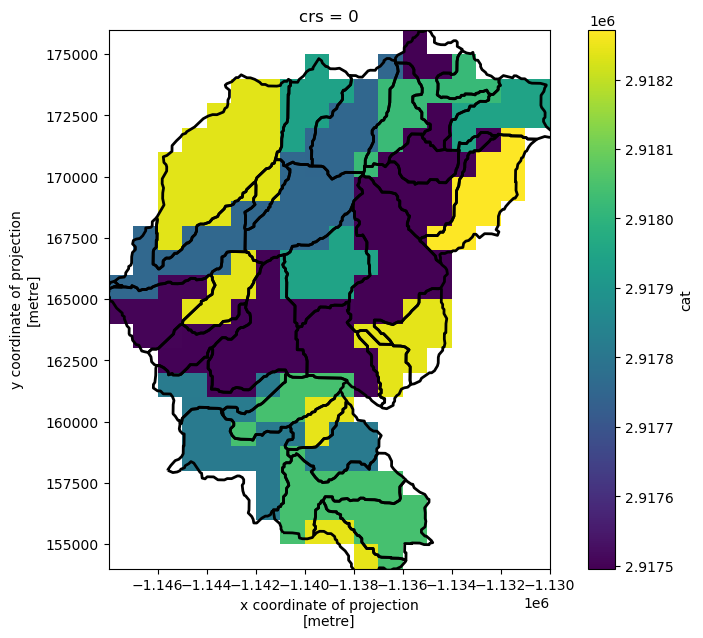

In [10]:
figure, ax = plt.subplots(figsize=(10,7))


# plot the gridded catchment mapping
ds.cat.plot()

## create a discrete color mapping such that each catchment 
## is represented by a single color
# cmap = colors.ListedColormap(['green', 'lightskyblue', 'cyan', 'red', 'navy'])
# bounds = [catchment_ids[0]] + [c+0.9 for c in catchment_ids]
# norm = colors.BoundaryNorm(bounds, cmap.N)
# ds.cat.plot(cmap=cmap, norm=norm, ax=ax)

# preview map geometries
gdf.iloc[:].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');


Define functions that will be used to perform basin averages on the AORC data. These functions leverage `dask` to parallelize the computation.

In [18]:
# call once per catchment
# distribute zonal stats to sub processes
def perform_zonal_computation(ds, cat_id):

    # subset by catchment id
    ds_catchment = ds.where(ds.cat==cat_id, drop=True)
#    ds_catchement_future = client.scatter(ds_catchment, broadcast=True)
    
    delayed = []
    # loop over variables
    for variable in ['LQFRAC', 'LWDOWN', 'PSFC',
                     'Q2D', 'RAINRATE', 'SWDOWN',
                     'T2D', 'U2D', 'V2D']:
                
        delay = dask.delayed(compute_zonal_mean)(ds_catchment[variable], variable)
        delayed.append(delay)
        
    res = dask.compute(*delayed)
    
    # combine outputs (list of dicts) into a single dict.
    res = {k: v for d in res for k, v in d.items()}
    
    # return results
    return {f'cat-{int(cat_id)}': res}

def compute_zonal_mean(ds, variable):
    return {variable: ds.mean(dim=['x','y']).values}

Slice the data to the temporal period of our choice.

In [12]:
# define the start and end time of the data we want to use
start_time = '2010-01-01 00:00'
end_time = '2010-01-10 00:00'


# isolate the desired time period of our data
ds_subset = ds.sortby('time').sel(time=slice(start_time, end_time))

print(f'The dataset contains {len(ds_subset.time)} timesteps')

The dataset contains 217 timesteps


Let's rechunk our data now that we have many fewer elements.

In [13]:
ds_subset.chunks

Frozen({'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'y': (22,), 'x': (18,)})

In [14]:
ds_subset = ds_subset.chunk(chunks={'time': 1000})

In [15]:
ds_subset.chunks

Frozen({'y': (22,), 'x': (18,), 'time': (217,)})

Drop all data that we don't need. The goal here is to make the dataset as small as possible before we start running computations on the data.

In [16]:
# drop unused coordinates
ds = ds.drop(['crs','lat','lon'])

Tell `dask` to perform the subsetting computations on the data now. That way when we process the zonal statistics, the entire dataset won't need to be moved around. This will save a considerable amount of processing in future steps time.

In [17]:
%%time 
ds_subset = ds_subset.compute()

CPU times: user 7.18 s, sys: 801 ms, total: 7.98 s
Wall time: 39.1 s


Scatter the dataset to the cluster so all workers will have access to it. This is good practice and especially necessary if working on a large dataset.

In [19]:
%%time
scattered_ds = client.scatter(ds_subset, broadcast=True)

CPU times: user 61.2 ms, sys: 4.23 ms, total: 65.4 ms
Wall time: 145 ms


Build a list of `delayed` tasks. This will not execute the computation.

In [20]:
%%time
delayed = []

# loop over each catchment in our domain
# create delayed tasks to compute zonal mean
for cat_id in catchment_ids:
    delay = dask.delayed(perform_zonal_computation)(scattered_ds, cat_id)
    delayed.append(delay)

CPU times: user 1.67 ms, sys: 1.14 ms, total: 2.81 ms
Wall time: 2.2 ms


Invoke the computation using `dask.compute`.

In [21]:
%%time 

# run the computation
results = dask.compute(*delayed)

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/nanops.py:119: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 463 ms, sys: 40.5 ms, total: 503 ms
Wall time: 973 ms


Save the basin averaged meteorological data in the format expected by `ngen`.

The summarized AORC variables need to be mapped to the `ngen` model that we'll be using. The following table illustrates the mapping.

|AORC Variable Name|NGEN Variable Name|Description|
|---|---|---|
| LQFRAC   | ---                   | Fraction of precipitation that is liquid vs. frozen (%)
| LWDOWN   | DLWRF_surface         | Surface downward long-wave radiation flux (W m-2) 
| PSFC     | PRES_surface          | Surface Pressure (Pa)
| Q2D      | SPFH_2maboveground    | 2-m Specific Humidity (kg kg-1)
| RAINRATE | ---                   | precipitation_flux (mm s^-1)
| SWDOWN   | DSWRF_surface         | Surface downward short-wave radiation flux (W m-2)
| T2D      | TMP_2maboveground     | 2-m Air Temperature (K)
| U2D      | UGRD_10maboveground   | 10-m U-component of wind (m s-1)
| V2D      | VGRD_10maboveground   | 10-m V-component of wind (m s-1)
| ---      | APCP_surface          | Surface precipitation (kg/m^2)

Note: our `ngen` model is expecting shortwave and longwave radiation at a height of 0 meters above ground whereas the AORC data has values are 2 meters above ground.

References: [tshirt_c.h](https://github.com/NOAA-OWP/ngen/blob/f2725dfbb52f3af5083ce927e69733edbf059f57/models/tshirt/include/tshirt_c.h#L52), [sample forcing csv](https://github.com/NOAA-OWP/ngen/blob/master/data/forcing/cat-27_2015-12-01%2000_00_00_2015-12-30%2023_00_00.csv)

In [ ]:

# compute the date range for our data using start and end times
# that were used in the subsetting process.
dates = pandas.date_range(start_time, end_time, freq="60min")

# save the zonal means for each catchment
for dat in results:
    for cat in dat:
        df = pandas.DataFrame({k:list(v) for k,v in dat[cat].items()})
        df.fillna(0., inplace=True)
        
        # convert rainrate from mm/s to kg/m2
        # mm/s - mm/hr = df.RAINRATE * 3600
        # since the timestep is one hour, this is effectively the total rain in mm.
        # 1 mm of rainfall is equal to 1kg/m2 so our conversion is:
        # NOTE: we should only be considering the fraction of liquid precip which can
        #       be computed using LQFRAC. However LQFRAC is zero for our data which 
        #       does not seem correct, so we'll assume that all precip is liquid. This
        #       is something that needs to be revisited.
        df['APCP_surface'] = df.RAINRATE * 3600

        # rename columns to match the variable names expected by the ngen t-shirt model
        df.rename(columns={
            'LWDOWN'   : 'DLWRF_surface',
            'PSFC'     : 'PRES_surface',
            'Q2D'      : 'SPFH_2maboveground',
            'SWDOWN'   : 'DSWRF_surface',
            'T2D'      : 'TMP_2maboveground',
            'U2D'      : 'UGRD_10maboveground',
            'V2D'      : 'VGRD_10maboveground',
            'RAINRATE' : 'precip_rate',
        },
                  inplace=True)
        
        # drop LQFRAC because it's not needed
        df.drop(columns=['LQFRAC'], inplace=True)
        
        # add the time index
        df['time'] = dates
        df.set_index('time', inplace=True)


        # write to file
        with open(f'{wb_id}/forcings/{cat}.csv', 'w') as f:
            # Note: saving "precip_rate" because this column exists in the example 
            #       forcing files. It's not clear if this is being used or not.
            df.to_csv(f,
                      columns = ['APCP_surface',
                                 'DLWRF_surface',
                                 'DSWRF_surface',
                                 'PRES_surface',
                                 'SPFH_2maboveground',
                                 'TMP_2maboveground',
                                 'UGRD_10maboveground',
                                 'VGRD_10maboveground',
                                 'precip_rate'])
            